In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
from torch.nn.utils import weight_norm

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

1
True
11.8


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
import random

#Set seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
# 데이터 로드 및 전처리 함수
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, header=None)
    data = df.values
    return data

# 다중 타임 스텝 데이터를 생성하는 함수
def create_multistep_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

[[0.36328772 0.35860745 0.34462677 0.        ]
 [0.36185333 0.36090248 0.34307763 0.        ]
 [0.36125089 0.35832058 0.3436227  0.        ]
 ...
 [0.49923909 0.50414001 0.50852861 0.        ]
 [0.49968916 0.50392331 0.50819523 0.        ]
 [0.49942245 0.5038733  0.50814522 0.        ]]


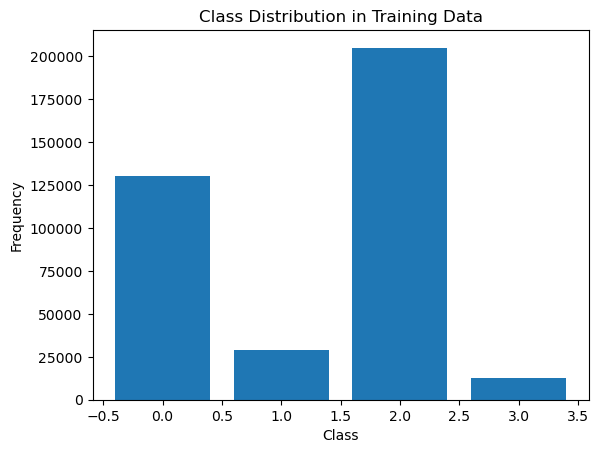

(376687, 3)


In [6]:
# 모든 학습 데이터 로드 및 병합
all_data = []

file_paths = [f"C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Labeling Data\\F{i}_combined.csv" for i in range(1, 51)]
for file_path in file_paths:
    data = load_and_preprocess(file_path)
    all_data.append(data)

all_data = np.vstack(all_data)

print(all_data)

# 데이터 분포 확인
plt.hist(all_data[:, 3], bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

print(all_data[:, :3].shape)

In [7]:
# 다중 타임 스텝 데이터 생성
time_steps = 100  # 예시로 3개의 타임 스텝을 고려
X, y = create_multistep_data(all_data, time_steps)
y = y.astype(int)

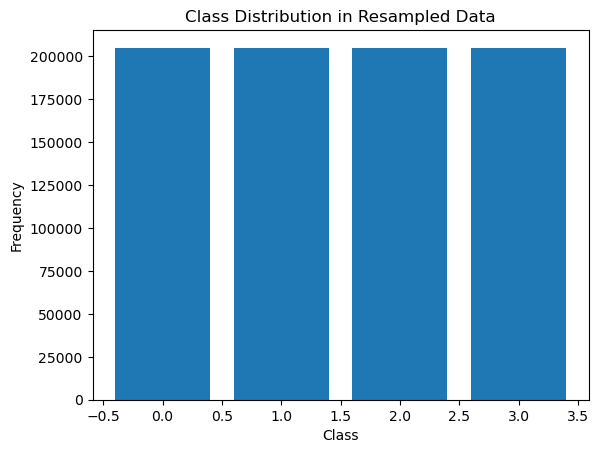

In [8]:
# 데이터 증강 (SMOTE)
smote = SMOTE()
X_reshaped = X.reshape(X.shape[0], -1)  # SMOTE를 적용하기 위해 2D 형태로 변환
X_res, y_res = smote.fit_resample(X_reshaped, y)
X_res = X_res.reshape(X_res.shape[0], time_steps, X.shape[2])  # 다시 3D 형태로 변환

# 증강된 데이터의 클래스 분포 확인
plt.hist(y_res, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Resampled Data')
plt.show()

In [9]:
# PyTorch 데이터셋 및 데이터로더 생성
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [10]:
# TCN 모델 정의
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, input_size, num_channels, output_size, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        x = x.permute(0, 2, 1)  # (batch_size, input_size, time_steps)
        y = self.tcn(x)  # (batch_size, num_channels[-1], time_steps)
        y = y[:, :, -1]  # (batch_size, num_channels[-1])
        return self.fc(y)

In [11]:
input_size = X_res.shape[2]
output_size = 4
num_channels = [64, 128, 256]  # TCN의 채널 개수
kernel_size = 2
dropout = 0.2

model = TCNModel(input_size, num_channels, output_size, kernel_size, dropout).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\jy\anaconda3\envs\jy3\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [12]:
import torch.nn.functional as F

def custom_loss(outputs, labels):
    softmax_outputs = F.log_softmax(outputs, dim=1)
    return F.nll_loss(softmax_outputs, labels)

In [13]:
model

TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 64, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(64, 128, kernel_size=(2,), stride=(1

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Loss가 개선되지 않는 epoch 수
            min_delta (float): 이전 Loss 대비 개선된 것으로 인정할 최소 감소량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 학습 루프에 조기 중단 로직 적용
early_stopping = EarlyStopping(patience=5, min_delta=0.1)

In [15]:
# num_epochs = 100

# # 모델 학습 함수
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
#     train_accuracy, train_losses, val_losses, val_accuracy = [], [], [], []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct = 0, 0
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             train_correct += (predicted == y_batch).sum().item()
        
#         train_accuracy.append(train_correct / len(train_dataset))
#         train_losses.append(train_loss / len(train_loader))

#         model.eval()
#         val_loss, correct = 0, 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 correct += (predicted == y_batch).sum().item()

#         val_losses.append(val_loss / len(val_loader))
#         val_accuracy.append(correct / len(val_dataset))
#         print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_correct / len(train_dataset):.4f}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / len(val_dataset):.4f}')
    
#     return train_accuracy, train_losses, val_losses, val_accuracy

# # 모델 학습
# train_accuracy, train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


In [16]:
import matplotlib.pyplot as plt

num_epochs=100

# 학습 및 검증 손실과 정확도를 저장할 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in data_loader:
        inputs, labels = batch[:2]
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def e_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[:2]
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# 학습 루프
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = e_model(model, val_loader, criterion, device)

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/100, Train Loss: 1.1646, Train Accuracy: 0.4571, Val Loss: 1.1172, Val Accuracy: 0.4893
Epoch 2/100, Train Loss: 1.1058, Train Accuracy: 0.4964, Val Loss: 1.0765, Val Accuracy: 0.5229
Epoch 3/100, Train Loss: 1.0724, Train Accuracy: 0.5161, Val Loss: 1.0549, Val Accuracy: 0.5309
Epoch 4/100, Train Loss: 1.0491, Train Accuracy: 0.5286, Val Loss: 1.0291, Val Accuracy: 0.5381
Epoch 5/100, Train Loss: 1.0283, Train Accuracy: 0.5376, Val Loss: 1.0348, Val Accuracy: 0.5432
Epoch 6/100, Train Loss: 1.0110, Train Accuracy: 0.5460, Val Loss: 0.9884, Val Accuracy: 0.5545
Epoch 7/100, Train Loss: 0.9951, Train Accuracy: 0.5529, Val Loss: 0.9687, Val Accuracy: 0.5657
Epoch 8/100, Train Loss: 0.9819, Train Accuracy: 0.5591, Val Loss: 0.9547, Val Accuracy: 0.5727
Epoch 9/100, Train Loss: 0.9687, Train Accuracy: 0.5658, Val Loss: 0.9405, Val Accuracy: 0.5800
Epoch 10/100, Train Loss: 0.9587, Train Accuracy: 0.5701, Val Loss: 0.9255, Val Accuracy: 0.5871
Epoch 11/100, Train Loss: 0.9484, Train

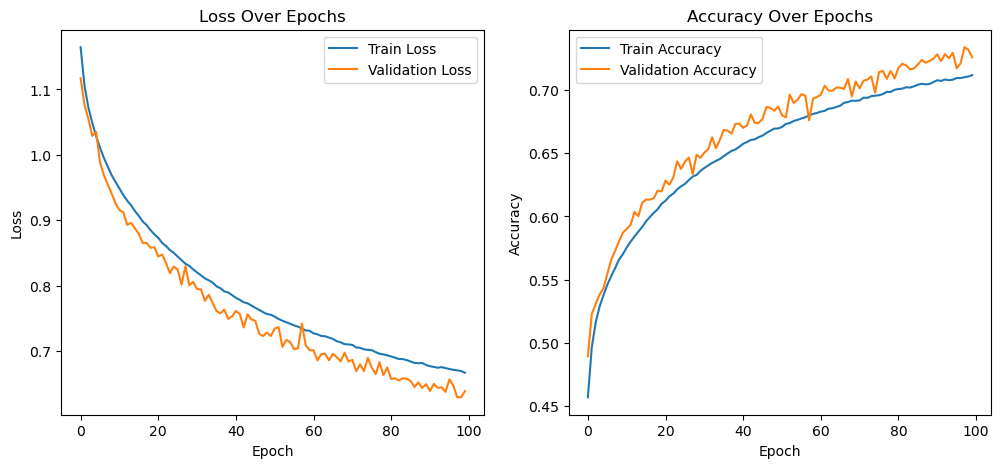

In [17]:
# 학습 과정의 손실 값과 정확도 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Test Loss: 0.299047704488742
Test Accuracy: 94.82%
Confusion Matrix:
[[ 3219    22     0    84]
 [  219   409   107    20]
 [   24    72 14927   339]
 [   69    10    62   251]]


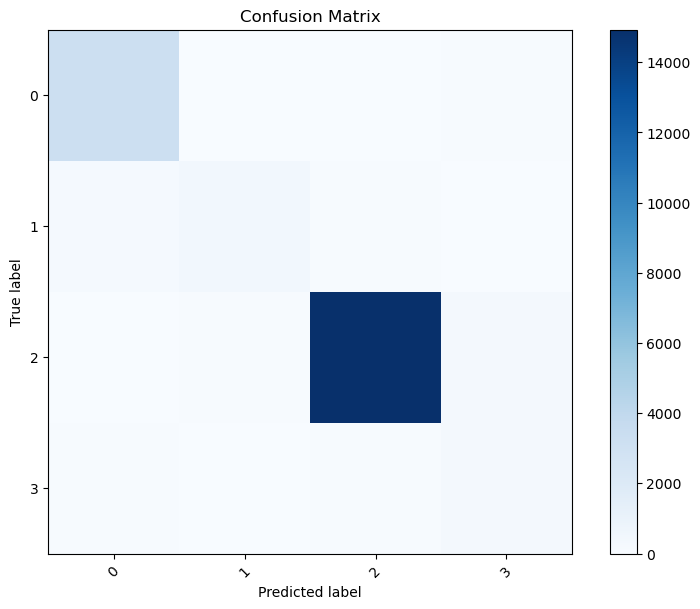

In [20]:
# 테스트 데이터 로드 및 전처리
test_file_path = "C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Labeling Data\\F51_combined.csv"
test_data = load_and_preprocess(test_file_path)

# 테스트 데이터도 다중 타임 스텝 데이터로 변환
X_test, y_test = create_multistep_data(test_data, time_steps)
y_test = y_test.astype(int)

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 모델 평가
model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = correct / len(test_dataset)
conf_matrix = confusion_matrix(y_true, y_pred)
acc_score = accuracy_score(y_true, y_pred)

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, [0, 1, 2, 3], rotation=45)
plt.yticks(tick_marks, [0, 1, 2, 3])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
model_save_path = os.path.join("tcn_model_test.pth")

# 모델 저장
torch.save(model.state_dict(), model_save_path)

def save_model_to_onnx(model, input_size, file_name="tcn_model_test.onnx"):
    model.eval()
    dummy_input = torch.randn(1, time_steps, input_size).to(device)
    torch.onnx.export(model, dummy_input, file_name, 
                      export_params=True,        
                      opset_version=14,          # ONNX 버전
                      do_constant_folding=True,  
                      input_names = ['input'],   
                      output_names = ['output'], 
                      dynamic_axes={'input' : {0 : 'batch_size'},    
                                    'output' : {0 : 'batch_size'}})
    print(f"Model saved as {file_name}")

save_model_to_onnx(model, input_size)

Model saved as tcn_model_test.onnx
